In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh
from tqdm.autonotebook import tqdm
from pytorch3d.io import save_obj
import pandas as pd

import postprocess_dataset
from utils import utils, visualization_tools, nn_pose_est, eval_utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1, sample_points
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist
from mesh_refiner import MeshRefiner

In [4]:
class_name = "02933112"
input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_name)
input_img_dir = "data/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
gt_shapes_list_path = "data/gt_shapes_path_lists/shapenet_{}_gt_shapes.lst".format(class_name)
cfg_path = "configs/final_refinement_params.yaml"

device = torch.device("cuda:0")
cfg = utils.load_config(cfg_path, "configs/default.yaml")
gt_shapes_dict = {}
with open(gt_shapes_list_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]
pose_dict = pickle.load(open(os.path.join(input_img_dir, "renders_camera_params.pt"), "rb"))
instances = [str(path).split('/')[-1].replace(".obj", "") for path in list(Path(input_mesh_dir).rglob("*.obj"))]

instances = instances[10:25]
print(instances)
print(cfg)

['c4db384855e345009f8c3d2002c77ddb', 'ba5e1671d26af2763c6c38b12db4d8f3', 'fe5f6a2aab0091438860c69ebde1e4b8', 'd5058b014492f748220c986172788383', 'dfe503e6a4a86d4dc59350d819542ec7', 'd7fe270a81b0f21c3fe047712e43e185', 'bb0255c8582c74c6557f50690310ce8d', 'd33e54d1880f70c310cd758d9b7cf', 'df55c6665781293cbe53b3b9f1274310', 'c55a7e2cb3ab9aea8ca4aeb5e3b33af7', 'cb70b087e5bc5e9522e46d8e163c0f81', 'b74f87f4d4c7da7343638dabe1eb5336', 'b8300f2e4a8adf9b31de0931bd5b560c', 'd4f4b5bf712a96b13679ccb6aaef8b00', 'cae4ad6aa7d0e49df160c00ab31497df']
{'dataset': {'input_dir_mesh': 'data/onet_chair_shapent_no_DA_simplified', 'input_dir_img': 'data/img_shapenet_chair', 'gt_shapes_lst_path': 'data/gt_shapes_path_lists/shapenet_chair_gt_shapes.lst'}, 'brute_force_pose_est': {'num_azims': 20, 'num_elevs': 20, 'num_dists': 40}, 'model': {'point_encoder': 'ResnetPointnet', 'image_encoder': 'Resnet18', 'deformation_decoder': 'FCStandard', 'latent_dim_pointnet': 512, 'latent_dim_resnet': 256, 'decoder_dim': 1024,

c4db384855e345009f8c3d2002c77ddb
1.3333332538604736 123.15789794921875 94.73684692382812 bf


/home/svcl-oowl/brandon/research/sil_consistent_at_inference/evaluation.py:73: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427286/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  input_img_mask = torch.tensor(np.asarray(input_img))[:,:,3] > 0


Input mesh metrics: {'2d_iou_multi': 0.8502555886904398, '2d_iou_input': 0.3558770716190338, '3d_iou': 0.76175845, 'chamfer_L1': 0.0008128667250275612}


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Refined mesh metrics: {'2d_iou_multi': 0.5806652071575323, '2d_iou_input': 0.854397177696228, '3d_iou': 0.25094968, 'chamfer_L1': 0.01096412818878889}


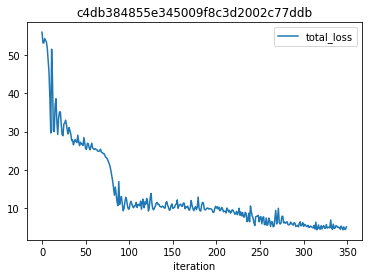

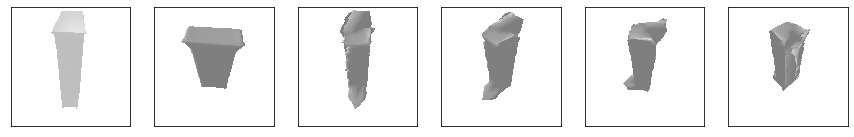

ba5e1671d26af2763c6c38b12db4d8f3
1.2692307233810425 151.57894897460938 18.947368621826172 bf
Input mesh metrics: {'2d_iou_multi': 0.7899264469742775, '2d_iou_input': 0.8978944420814514, '3d_iou': 0.00010596588, 'chamfer_L1': 0.0005546990432776511}



Refined mesh metrics: {'2d_iou_multi': 0.8267816305160522, '2d_iou_input': 0.9687798023223877, '3d_iou': 0.00016919519, 'chamfer_L1': 0.004915442783385515}


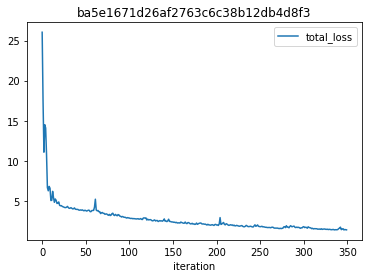

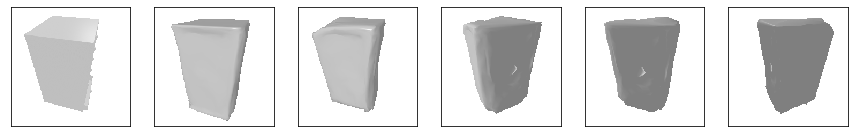

fe5f6a2aab0091438860c69ebde1e4b8
1.2051281929016113 28.421052932739258 341.0526428222656 bf
Input mesh metrics: {'2d_iou_multi': 0.8039776881535848, '2d_iou_input': 0.9043440818786621, '3d_iou': 0.58420604, 'chamfer_L1': 0.006884588859975338}



Refined mesh metrics: {'2d_iou_multi': 0.7800399164358774, '2d_iou_input': 0.9770601391792297, '3d_iou': 0.5321674, 'chamfer_L1': 0.007350725121796131}


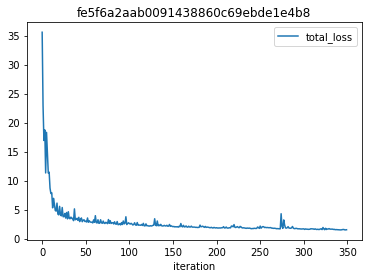

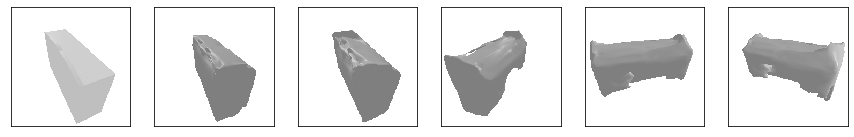

d5058b014492f748220c986172788383
1.0769230127334595 28.421052932739258 170.5263214111328 bf
Input mesh metrics: {'2d_iou_multi': 0.9043332586685816, '2d_iou_input': 0.442844957113266, '3d_iou': 0.20877178, 'chamfer_L1': 0.0006839119596406817}



Refined mesh metrics: {'2d_iou_multi': 0.7525888172288736, '2d_iou_input': 0.9181091785430908, '3d_iou': 0.12015738, 'chamfer_L1': 0.0033539729192852974}


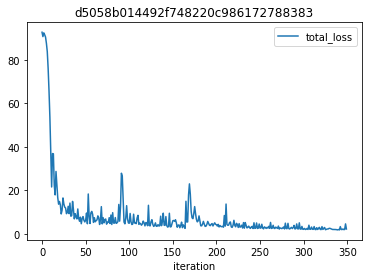

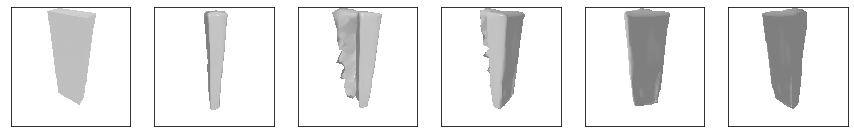

dfe503e6a4a86d4dc59350d819542ec7
1.2692307233810425 28.421052932739258 113.68421173095703 bf
Input mesh metrics: {'2d_iou_multi': 0.7792151148120562, '2d_iou_input': 0.8608949780464172, '3d_iou': 0.06583888, 'chamfer_L1': 0.0039502293802797794}



Refined mesh metrics: {'2d_iou_multi': 0.8071155498425165, '2d_iou_input': 0.9671618342399597, '3d_iou': 0.05471567, 'chamfer_L1': 0.0030488939955830574}


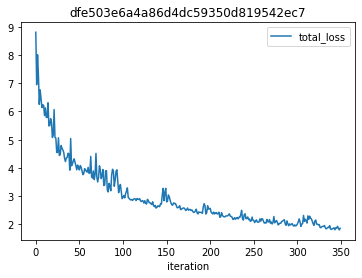

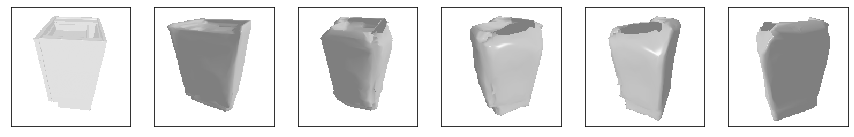

d7fe270a81b0f21c3fe047712e43e185
1.2692307233810425 28.421052932739258 341.0526428222656 bf
Input mesh metrics: {'2d_iou_multi': 0.771273838977019, '2d_iou_input': 0.7792320251464844, '3d_iou': 0.77044976, 'chamfer_L1': 0.0019229082390666008}



Refined mesh metrics: {'2d_iou_multi': 0.751878614226977, '2d_iou_input': 0.8945702910423279, '3d_iou': 0.72217786, 'chamfer_L1': 0.0032846559770405293}


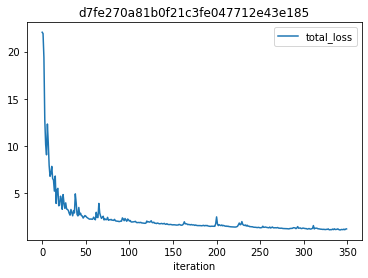

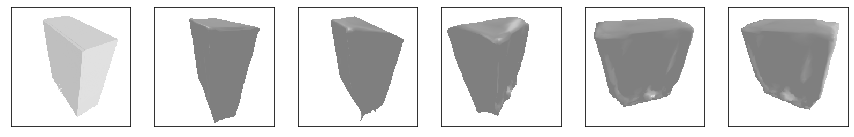

bb0255c8582c74c6557f50690310ce8d
1.0769230127334595 151.57894897460938 189.47369384765625 bf
Input mesh metrics: {'2d_iou_multi': 0.8503733227650324, '2d_iou_input': 0.5301627516746521, '3d_iou': 0.094225176, 'chamfer_L1': 0.00216109910979867}



Refined mesh metrics: {'2d_iou_multi': 0.7825421616435051, '2d_iou_input': 0.7311543822288513, '3d_iou': 0.07633614, 'chamfer_L1': 0.003982835449278355}


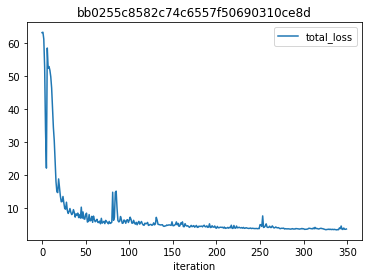

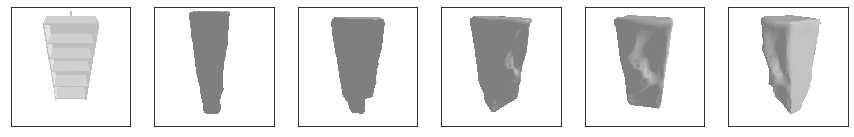

d33e54d1880f70c310cd758d9b7cf
1.2692307233810425 28.421052932739258 170.5263214111328 bf
Input mesh metrics: {'2d_iou_multi': 0.8362733125686646, '2d_iou_input': 0.7625632882118225, '3d_iou': 0.23581402, 'chamfer_L1': 0.003272382542490959}



Refined mesh metrics: {'2d_iou_multi': 0.8164911593000094, '2d_iou_input': 0.9208106398582458, '3d_iou': 0.22367582, 'chamfer_L1': 0.0030826956499367952}


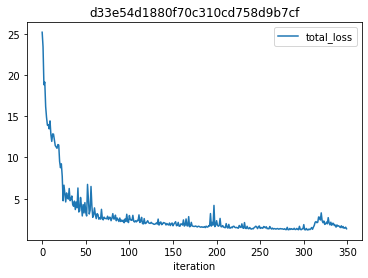

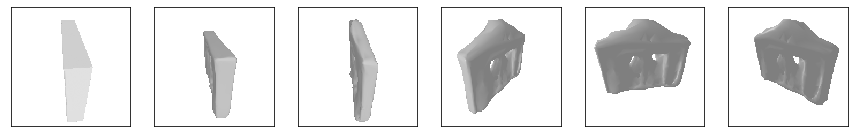

df55c6665781293cbe53b3b9f1274310
1.2692307233810425 37.894737243652344 341.0526428222656 bf
Input mesh metrics: {'2d_iou_multi': 0.7902620087067286, '2d_iou_input': 0.8725888133049011, '3d_iou': 0.7710413, 'chamfer_L1': 0.0023579783737659454}



Refined mesh metrics: {'2d_iou_multi': 0.770115002989769, '2d_iou_input': 0.9770697951316833, '3d_iou': 0.74316233, 'chamfer_L1': 0.0023402362130582333}


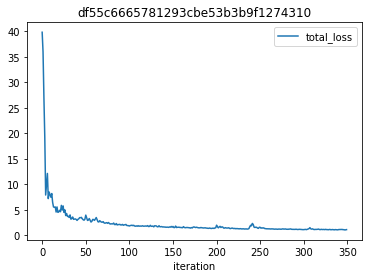

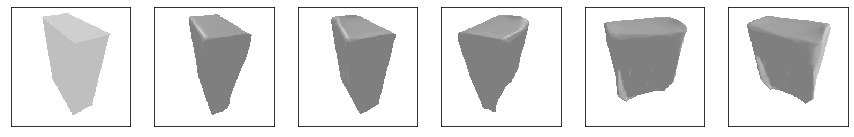

c55a7e2cb3ab9aea8ca4aeb5e3b33af7
1.1410256624221802 28.421052932739258 151.57894897460938 bf
Input mesh metrics: {'2d_iou_multi': 0.8211243574817976, '2d_iou_input': 0.8814752697944641, '3d_iou': 0.6483525, 'chamfer_L1': 0.0026152310892939568}



Refined mesh metrics: {'2d_iou_multi': 0.7507466425498327, '2d_iou_input': 0.9634648561477661, '3d_iou': 0.58590823, 'chamfer_L1': 0.003520713886246085}


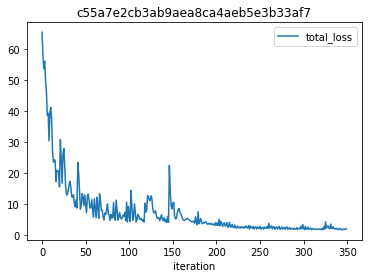

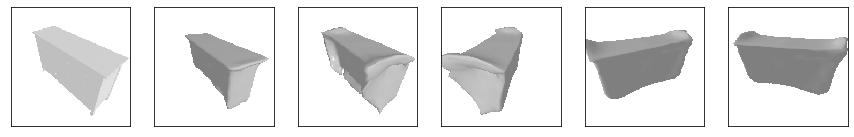

cb70b087e5bc5e9522e46d8e163c0f81
1.1410256624221802 151.57894897460938 246.3157958984375 bf
Input mesh metrics: {'2d_iou_multi': 0.8509566386540731, '2d_iou_input': 0.9271988272666931, '3d_iou': 0.7910824, 'chamfer_L1': 0.0012412306386977434}



Refined mesh metrics: {'2d_iou_multi': 0.8323004196087519, '2d_iou_input': 0.9805036783218384, '3d_iou': 0.83718956, 'chamfer_L1': 0.0008702618652023375}


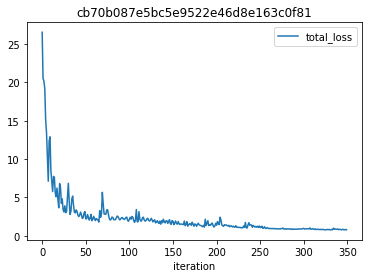

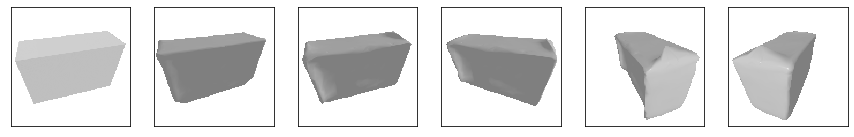

b74f87f4d4c7da7343638dabe1eb5336
1.2051281929016113 47.36842346191406 0.0 bf
Input mesh metrics: {'2d_iou_multi': 0.8095560446381569, '2d_iou_input': 0.766617476940155, '3d_iou': 0.12593342, 'chamfer_L1': 0.0032279244624078274}



Refined mesh metrics: {'2d_iou_multi': 0.7687076330184937, '2d_iou_input': 0.9523958563804626, '3d_iou': 0.1139339, 'chamfer_L1': 0.007645853795111179}


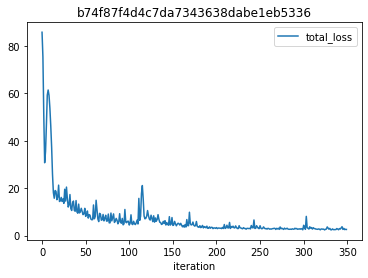

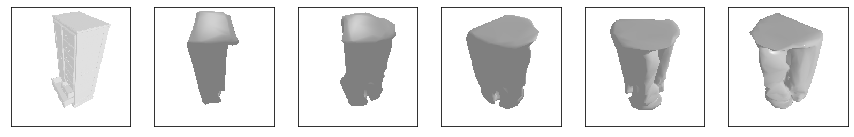

b8300f2e4a8adf9b31de0931bd5b560c
1.1410256624221802 28.421052932739258 303.15789794921875 bf
Input mesh metrics: {'2d_iou_multi': 0.7144426330924034, '2d_iou_input': 0.8134778141975403, '3d_iou': 0.10345988, 'chamfer_L1': 0.0027157056611031294}



Refined mesh metrics: {'2d_iou_multi': 0.7737569138407707, '2d_iou_input': 0.9277944564819336, '3d_iou': 0.1094564, 'chamfer_L1': 0.0017963727004826069}


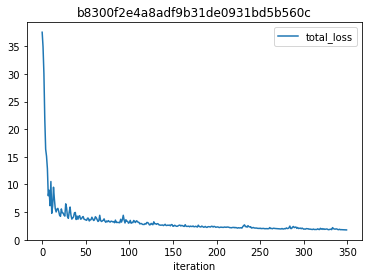

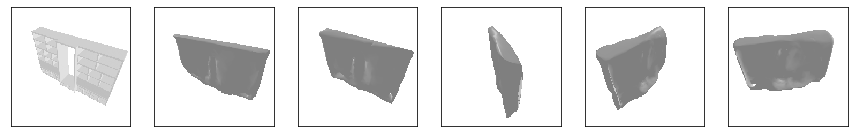

d4f4b5bf712a96b13679ccb6aaef8b00
1.0769230127334595 37.894737243652344 284.21051025390625 bf
Input mesh metrics: {'2d_iou_multi': 0.8576136430104574, '2d_iou_input': 0.8888258934020996, '3d_iou': 0.2704713, 'chamfer_L1': 0.0015645564999431372}



Refined mesh metrics: {'2d_iou_multi': 0.8536059558391571, '2d_iou_input': 0.9628629088401794, '3d_iou': 0.33513674, 'chamfer_L1': 0.0014481056714430451}


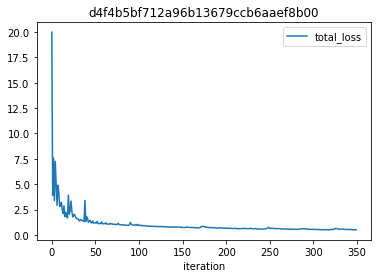

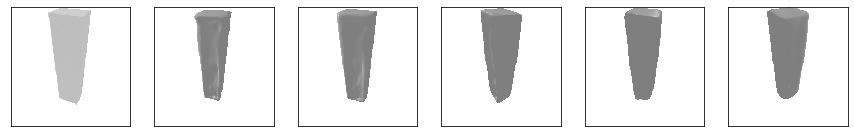

cae4ad6aa7d0e49df160c00ab31497df
1.1410256624221802 151.57894897460938 18.947368621826172 bf
Input mesh metrics: {'2d_iou_multi': 0.8378341073791186, '2d_iou_input': 0.8216108083724976, '3d_iou': 0.7850206, 'chamfer_L1': 0.0015522213652729988}



Refined mesh metrics: {'2d_iou_multi': 0.8313024540742239, '2d_iou_input': 0.9519186615943909, '3d_iou': 0.7538356, 'chamfer_L1': 0.0015845017042011023}


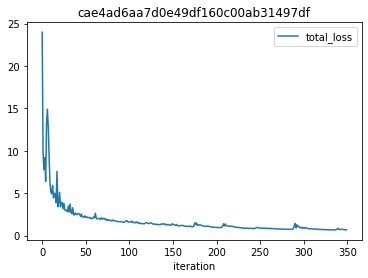

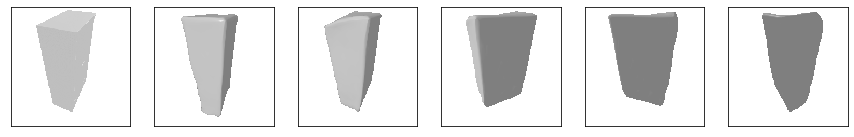

In [5]:
num_azims=20
num_elevs=20
num_dists=40

pose_settings=["bf"]

results_df = pd.DataFrame()
for instance in instances:
    print(instance)
    input_img_path = os.path.join(input_img_dir,"{}.png".format(instance))
    input_image = np.asarray(Image.open(input_img_path))
    input_mesh_path = os.path.join(input_mesh_dir,"{}.obj".format(instance))
    gt_mesh_path = gt_shapes_dict[instance.split("_")[0]]
    with torch.no_grad():
        input_mesh = utils.load_untextured_mesh(input_mesh_path, device)
        gt_mesh = utils.load_untextured_mesh(gt_mesh_path, device)
    input_trimesh= trimesh.load(input_mesh_path)
    gt_trimesh = trimesh.load(gt_mesh_path)
    mask = np.asarray(input_image)[:,:,3] > 0
    
    instance_info = {"instance": instance}
    
    pose_info_list = []
    if "gt" in pose_settings:
        gt_elev = pose_dict[instance]["elev"]
        gt_azim = pose_dict[instance]["azim"]
        _, _, gt_dist, _, _ = brute_force_estimate_dist(input_mesh, mask, gt_azim, gt_elev, num_dists, device)
        pose_info_list.append([gt_dist.item(), gt_elev, gt_azim, "gt"])
    if "bf" in pose_settings:
        bf_pred_azim, bf_pred_elev, bf_pred_dist, _, _ = brute_force_estimate_pose(input_mesh, mask, num_azims, num_elevs, num_dists, device)
        pose_info_list.append([bf_pred_dist.item(), bf_pred_elev.item(), bf_pred_azim.item(), "bf"])
        
    for (dist, elev, azim, name) in pose_info_list:
        print(dist, elev, azim, name)
        input_metrics_dict, input_debug_dict = eval_utils.eval_metrics(input_image, input_trimesh, input_mesh, gt_trimesh, 
                                                                       gt_mesh, device, metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1"],
                                                                       pred_azim=azim, pred_elev=elev, pred_dist=dist)
        instance_info = {**instance_info, **{"original_{}_{}".format(name, metric):input_metrics_dict[metric] for metric in input_metrics_dict}}
        print("Input mesh metrics: {}".format(input_metrics_dict))
        
        
        
        mesh_refiner = MeshRefiner(cfg, device)
        refined_mesh, loss_info = mesh_refiner.refine_mesh(input_mesh, input_image, dist, elev, azim)
        refined_mesh_path = os.path.join("notebooks/out", "{}_{}.obj".format(instance, name))
        save_obj(refined_mesh_path, refined_mesh.verts_packed(), refined_mesh.faces_packed())
        refined_trimesh = trimesh.load(refined_mesh_path)
        refined_mesh = utils.load_untextured_mesh(refined_mesh_path, device)
        refined_metrics_dict, refined_debug_dict = eval_utils.eval_metrics(input_image, refined_trimesh, refined_mesh, gt_trimesh, gt_mesh, device, 
                                                                      metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1"],
                                                                      pred_azim=azim, pred_elev=elev, pred_dist=dist)
        print("Refined mesh metrics: {}".format(refined_metrics_dict))
        instance_info = {**instance_info, **{"refined_{}_{}".format(name, metric):refined_metrics_dict[metric] for metric in refined_metrics_dict}}

        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance))
        visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, dist, elev, azim, device)
    
    results_df = results_df.append(instance_info, ignore_index=True)
    print("=========================================================================================")


In [6]:
display(results_df)
print(results_df.mean())

,instance,original_bf_2d_iou_input,original_bf_2d_iou_multi,original_bf_3d_iou,original_bf_chamfer_L1,refined_bf_2d_iou_input,refined_bf_2d_iou_multi,refined_bf_3d_iou,refined_bf_chamfer_L1
0,c4db384855e345009f8c3d2002c77ddb,0.355877,0.850256,0.761758,0.000813,0.854397,0.580665,0.250950,0.010964
1,ba5e1671d26af2763c6c38b12db4d8f3,0.897894,0.789926,0.000106,0.000555,0.968780,0.826782,0.000169,0.004915
2,fe5f6a2aab0091438860c69ebde1e4b8,0.904344,0.803978,0.584206,0.006885,0.977060,0.780040,0.532167,0.007351
3,d5058b014492f748220c986172788383,0.442845,0.904333,0.208772,0.000684,0.918109,0.752589,0.120157,0.003354
4,dfe503e6a4a86d4dc59350d819542ec7,0.860895,0.779215,0.065839,0.003950,0.967162,0.807116,0.054716,0.003049
5,d7fe270a81b0f21c3fe047712e43e185,0.779232,0.771274,0.770450,0.001923,0.894570,0.751879,0.722178,0.003285
6,bb0255c8582c74c6557f50690310ce8d,0.530163,0.850373,0.094225,0.002161,0.731154,0.782542,0.076336,0.003983
7,d33e54d1880f70c310cd758d9b7cf,0.762563,0.836273,0.235814,0.003272,0.920811,0.816491,0.223676,0.003083
8,df55c6665781293cbe53b3b9f1274310,0.872589,0.790262,0.771041,0.002358,0.977070,0.770115,0.743162,0.002340
9,c55a7e2cb3ab9aea8ca4aeb5e3b33af7,0.881475,0.821124,0.648353,0.002615,0.963465,0.750747,0.585908,0.003521


original_bf_2d_iou_input    0.767041
original_bf_2d_iou_multi    0.817828
original_bf_3d_iou          0.414435
original_bf_chamfer_L1      0.002368
refined_bf_2d_iou_input     0.929870
refined_bf_2d_iou_multi     0.778576
refined_bf_3d_iou           0.363931
refined_bf_chamfer_L1       0.003946
dtype: float64
